
Simulating U = 6.0000

Simulating T = 0.2000

Simulating T = 0.1895

Simulating T = 0.1791

Simulating T = 0.1686

Simulating T = 0.1581

Simulating T = 0.1476

Simulating T = 0.1372

Simulating T = 0.1267

Simulating T = 0.1162

Simulating T = 0.1057

Simulating T = 0.0953

Simulating T = 0.0848

Simulating T = 0.0743

Simulating T = 0.0638

Simulating T = 0.0534

Simulating T = 0.0429

Simulating T = 0.0324

Simulating T = 0.0219

Simulating T = 0.0115

Simulating T = 0.0010


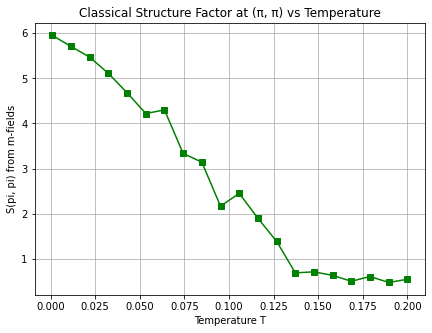

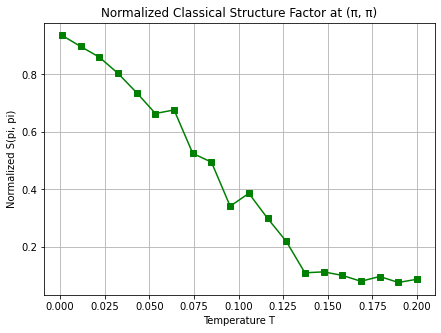

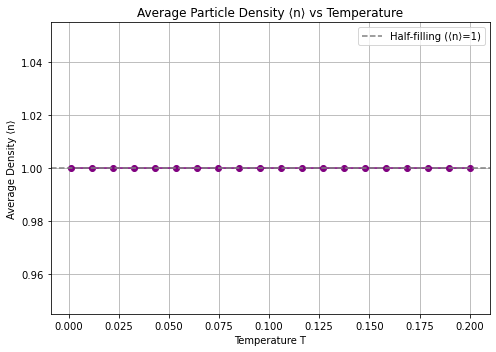

✅ Histogram data saved to: C:\Users\SHREEJIT\Desktop\Aux_Field_Output\U_6\m_histogram_data_6.csv
✅ DOS data saved to: C:\Users\SHREEJIT\Desktop\Aux_Field_Output\U_6\dos_data_6.csv
✅ Normalized structure factor data saved to: C:\Users\SHREEJIT\Desktop\Aux_Field_Output\U_6\normalized_structure_factor_vs_T_6.csv
✅ Number density data saved to: C:\Users\SHREEJIT\Desktop\Aux_Field_Output\U_6\n_density_vs_T_6.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import expit
import pandas as pd
from pathlib import Path
import os


# --- Parameters ---
L = 8  # Lattice size (LxL)
N = L * L
t = 1.0
T_min = 0.001
T_max = 0.20
T_steps = 20
eq_sweeps = 700
mc_sweeps = 400
sampling_gap = 10

U_values = [6.0]

output_dir = Path.home() / "Desktop" / "Aux_Field_Output" / "U_6"
output_dir.mkdir(parents=True, exist_ok=True)


#For Histogram data storing
histogram_records = []

# Initialize DOS records
dos_records = []

# Simulated structure factor and density data
temp_structure_records = []
structure_records = []
n_density_records = []

np.random.seed(42)

# --- Initialize lattice using spherical coordinates ---
def initialize_lattice(L, mod_m_max):

    theta = np.arccos(np.random.uniform(-1, 1, (L, L)))
    phi = np.random.uniform(0, 2 * np.pi, (L, L))

    # Step 2: Uniform sampling in volume (cube root of uniform distribution)
    mod_m = np.cbrt(np.random.uniform(0, mod_m_max**3, (L, L)))


    mx = mod_m * np.sin(theta) * np.cos(phi)
    my = mod_m * np.sin(theta) * np.sin(phi)
    mz = mod_m * np.cos(theta)

    return np.stack((mx, my, mz), axis=-1)


# --- Build effective Hamiltonian ---
def build_effective_hamiltonian(m_fields, t, mu, U):
    H_upup = np.zeros((N, N), dtype=np.complex128)
    H_downdown = np.zeros((N, N), dtype=np.complex128)
    H_updown = np.zeros((N, N), dtype=np.complex128)
    H_downup = np.zeros((N, N), dtype=np.complex128)
    for x in range(L):
        for y in range(L):
            i = x * L + y
            mx, my, mz = m_fields[x, y]
            H_upup[i, i] = -mz - (mu - U / 2)
            H_downdown[i, i] = mz - (mu - U / 2)
            B = -1 * (mx - 1j * my)
            H_updown[i, i] = B
            H_downup[i, i] = np.conjugate(B)
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                x_nn = (x + dx) % L
                y_nn = (y + dy) % L
                j = x_nn * L + y_nn
                H_upup[i, j] = H_upup[j, i] = -t
                H_downdown[i, j] = H_downdown[j, i] = -t
    top = np.hstack((H_upup, H_updown))
    bottom = np.hstack((H_downup, H_downdown))
    return np.vstack((top, bottom))

'''# --- Fermi function ---
def fermi_dirac(E, mu, beta):
    x = beta * E
    return np.where(x > 700, np.exp(-x), 1.0 / (np.exp(x) + 1.0))

def fermi_dirac(E, mu, beta):
    return expit(-beta * (E))'''


def fermi_dirac(E, mu, beta):
    x = beta * (E)
    result = np.empty_like(x)

    # Case 1: large x → f ≈ exp(-x) (numerically safe)
    mask_large = x > 700
    result[mask_large] = np.exp(-x[mask_large])

    # Case 2: small x → f ≈ 1 - exp(x) for x << -700
    mask_small = x < -700
    result[mask_small] = 1.0

    # Case 3: safe direct computation
    mask_middle = ~(mask_large | mask_small)
    result[mask_middle] = 1.0 / (np.exp(x[mask_middle]) + 1.0)

    return result


# --- Compute local densities ---
def compute_local_densities(eigvals, eigvecs, mu, beta):
    N2 = eigvecs.shape[0]
    N = N2 // 2
    local_up = np.zeros(N)
    local_down = np.zeros(N)
    for i in range(N):
        for alpha in range(N2):
            f_occ = fermi_dirac(eigvals[alpha], mu, beta)
            local_up[i] += f_occ * abs(eigvecs[i, alpha])**2
            local_down[i] += f_occ * abs(eigvecs[i+N, alpha])**2
    return local_up, local_down

# --- Classical structure factor ---
def compute_classical_structure_factor_pi_pi(m_fields):
    M_pi_pi = np.zeros(3)
    for x in range(L):
        for y in range(L):
            sign = (-1) ** (x + y)
            M_pi_pi += sign * m_fields[x, y]
    return np.dot(M_pi_pi, M_pi_pi) / (N ** 2)

def compute_dos_lorentzian(eigvals, energy_grid, eta, L):
    """
    Compute density of states using Lorentzian broadening.

    Parameters:
        eigvals      : array of 2N eigenvalues (including spin)
        energy_grid  : array of energy values for DOS
        eta          : Lorentzian broadening parameter
        L            : lattice size (system is L x L)

    Returns:
        dos : array of density of states values
    """
    N = L * L
    dos = np.zeros_like(energy_grid)

    for e in eigvals:
        dos += eta / ((energy_grid - e)**2 + eta**2)

    # Normalization: Lorentzian integrates to 1/π, and total states = 2N
    return (1 / (np.pi * 2 * N)) * dos

'''# --- Grand potential ---
def compute_grand_potential(eigvals, mu, beta):
    exponents = -beta * eigvals
    log_terms = np.where(exponents > 700, exponents, np.log1p(np.exp(exponents)))
    return -np.sum(log_terms) / beta'''


def compute_grand_potential(eigvals, mu, beta):
    x = -beta * (eigvals)
    result = np.empty_like(x)

    # Case 1: x > 700 → log(1 + exp(x)) ≈ x
    mask_large = x > 700
    result[mask_large] = x[mask_large]

    # Case 2: x < -700 → log(1 + exp(x)) ≈ exp(x)
    mask_small = x < -700
    result[mask_small] = np.exp(x[mask_small])

    # Case 3: safe region → compute directly
    mask_middle = ~(mask_large | mask_small)
    result[mask_middle] = np.log1p(np.exp(x[mask_middle]))

    return -np.sum(result) / beta


# --- Shift term ---
def compute_shift(m_fields, U):
    m_squared_sum = np.sum(m_fields ** 2)
    return (-N * U / 4) + (m_squared_sum / U)

# --- Init energy ---
def Init_en(m_fields, t, mu, U, beta):
    H_old = build_effective_hamiltonian(m_fields, t, mu, U)
    eigvals_old, eigvecs_old = eigh(H_old)
    E_old = compute_grand_potential(eigvals_old, mu, beta)
    shift_old = compute_shift(m_fields, U)
    E_prev = E_old + shift_old
    return eigvals_old, eigvecs_old, E_prev

# --- Metropolis update ---
def metropolis_update_optimized(m_fields, beta, mu, t, U, eigvals_old, eigvecs_old, E_prev, x, y):
    new_fields = m_fields.copy()
    new_vector = np.random.uniform(-5, 5, size=3)
    new_fields[x, y] = new_vector
    H_new = build_effective_hamiltonian(new_fields, t, mu, U)
    eigvals_new, eigvecs_new = eigh(H_new)
    E_new = compute_grand_potential(eigvals_new, mu, beta)
    shift_new = compute_shift(new_fields, U)
    E_curr = E_new + shift_new
    En_diff = E_curr - E_prev
    weight_diff = -beta * En_diff
    if En_diff < 0 or np.random.rand() < np.exp(weight_diff):
        return new_fields, E_curr, eigvals_new, eigvecs_new
    else:
        return m_fields, E_prev, eigvals_old, eigvecs_old

# === Setup ===
target_temperatures = np.linspace(T_max, T_min, T_steps)  # Set the T values for which to collect and plot DOS
dos_results = {}  # Will store: {T: (energy_grid, averaged DOS)}
colors = plt.cm.viridis(np.linspace(0, 1, len(np.linspace(T_max, T_min, T_steps))))

for U in U_values:
    print(f"\nSimulating U = {U:.4f}")
    mu = (U / 2)
    mod_m_max = 10.0
    temperatures = np.linspace(T_max, T_min, T_steps)
    m_fields = initialize_lattice(L, mod_m_max)

    structure_vs_T = []
    m_norms_vs_T = []
    n_vs_T = []

    for idx, T in enumerate(temperatures):
        beta = 1.0 / T
        is_target_T = np.any(np.isclose(T, target_temperatures, atol=1e-5))

        if idx == 0:
            eigvals_old, eigvecs_old, E_prev = Init_en(m_fields, t, mu, U, beta)

        for _ in range(eq_sweeps):
            for x in range(L):
                for y in range(L):
                    m_fields, E_prev, eigvals_old, eigvecs_old = metropolis_update_optimized(
                        m_fields, beta, mu, t, U, eigvals_old, eigvecs_old, E_prev, x, y
                    )

        print(f"\nSimulating T = {T:.4f}")
        m_norm_samples = []
        structure_factor_samples = []
        n_list = []
        m_Hist = []
        dos_samples = [] if is_target_T else None  # Only for target temperatures

        for sweep in range(mc_sweeps):
            for x in range(L):
                for y in range(L):
                    m_fields, E_prev, eigvals_old, eigvecs_old = metropolis_update_optimized(
                        m_fields, beta, mu, t, U, eigvals_old, eigvecs_old, E_prev, x, y
                    )

            if sweep % sampling_gap == 0:
                m_Hist.append(np.sqrt(np.sum((m_fields) ** 2, axis=-1)))

                #For local density
                local_up, local_down = compute_local_densities(eigvals_old, eigvecs_old, mu, beta)
                n_total = np.mean(local_up + local_down)
                n_list.append(n_total)

                #For classical structure factor
                S_classical = compute_classical_structure_factor_pi_pi(m_fields)
                structure_factor_samples.append(S_classical)

                #Normalization samples
                m_norm = np.sum(np.abs(m_fields) ** 2) / N
                m_norm_samples.append(m_norm)

                #For DOS
                if is_target_T:
                    E_min, E_max = np.min(eigvals_old) - 1, np.max(eigvals_old) + 1
                    energy_grid = np.linspace(E_min, E_max, 300)
                    eta = 0.05
                    dos_sample = compute_dos_lorentzian(eigvals_old, energy_grid, eta, L)
                    dos_samples.append(dos_sample)

        avg_S = np.mean(structure_factor_samples)
        m_norm_avg = np.mean(m_norm_samples)
        avg_n = np.mean(n_list)

        structure_vs_T.append(avg_S)
        m_norms_vs_T.append(m_norm_avg)
        n_vs_T.append(avg_n)

        # === Store averaged DOS if target temperature ===
        '''if is_target_T and dos_samples:
            dos_average = np.mean(dos_samples, axis=0)
            dos_results[T] = (energy_grid, dos_average)'''

        if is_target_T and dos_samples:
            dos_average = np.mean(dos_samples, axis=0)
            for ω, D in zip(energy_grid, dos_average):
                dos_records.append({
                'U': U,
                'T': T,
                'omega_minus_mu': ω,
                'dos': D
                })

        '''# === Plot histogram of |m| values ===
        flattened = np.array(m_Hist).flatten()
        plt.figure(figsize=(5, 4))
        #plt.hist(flattened, bins=60, range=[0, U], color='skyblue', edgecolor='black')
        hist, bins = np.histogram(flattened, bins=60,  range=[0, U], density=True)#color='skyblue', edgecolor='black')
        # Compute bin centers
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        # Plot histogram as line (not bar)
        plt.plot(bin_centers, hist, label=f"T = {T:.2f}", color=colors[idx], lw=2)
        plt.xlabel("|m_fields|")
        plt.ylabel("Occurrences (steps × sites)")
        plt.axvline(U / 2, color='red', linestyle='--', label="U/2")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()'''

        # === Store histogram data instead of plotting ===
        flattened = np.array(m_Hist).flatten()
        for m_val in flattened:
            histogram_records.append({'U': U, 'T': T, 'm_magnitude': m_val})


    # ✅ Store number density data (for this U) into the CSV record list
    for T_val, n_val in zip(temperatures, n_vs_T):
        n_density_records.append({'U': U, 'T': T_val, 'avg_n': n_val})


    # === Plot Classical Structure Factor at (pi, pi) vs Temperature ===
    plt.figure(figsize=(7, 5))
    plt.plot(temperatures, structure_vs_T, marker='s', color='green')
    plt.xlabel('Temperature T')
    plt.ylabel('S(pi, pi) from m-fields')
    plt.title('Classical Structure Factor at (π, π) vs Temperature')
    plt.grid(True)
    plt.show()

    # === Normalize structure factor ===
    m_norm_lowest_T = m_norms_vs_T[-1]
    normalized_structure_factors = [S / m_norm_lowest_T for S in structure_vs_T]

    plt.figure(figsize=(7, 5))
    plt.plot(temperatures, normalized_structure_factors, marker='s', color='green')
    plt.xlabel('Temperature T')
    plt.ylabel('Normalized S(pi, pi)')
    plt.title('Normalized Classical Structure Factor at (π, π)')
    plt.grid(True)
    plt.show()

    # Collect normalized structure factor data for CSV
    for T_val, S_norm in zip(temperatures, normalized_structure_factors):
        structure_records.append({'U': U, 'T': T_val, 'Normalized_S_pi_pi': S_norm})


    # === Plot average density vs temperature ===
    plt.figure(figsize=(7, 5))
    plt.plot(temperatures, n_vs_T, marker='o', color='purple')
    plt.xlabel('Temperature T')
    plt.ylabel('Average Density ⟨n⟩')
    plt.title('Average Particle Density ⟨n⟩ vs Temperature')
    plt.axhline(1.0, color='gray', linestyle='--', label='Half-filling (⟨n⟩=1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    '''# === Plot DOS for all collected target temperatures ===
    for T_val, (energy_grid, dos_avg) in dos_results.items():
        plt.figure(figsize=(6, 4))
        plt.plot(energy_grid, dos_avg, label=f"T = {T_val:.3f}")
        plt.xlabel("ω − μ")
        plt.ylabel("Density of States D(ω)")
        plt.title(f"DOS at T = {T_val:.3f}, U = {U}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()'''

# === Save all histogram data to CSV ===
hist_df = pd.DataFrame(histogram_records)
hist_csv_path = output_dir / "m_histogram_data_6.csv"
hist_df.to_csv(hist_csv_path, index=False)
print(f"✅ Histogram data saved to: {hist_csv_path}")

# === Save all DOS data to CSV ===
dos_df = pd.DataFrame(dos_records)
dos_csv_path = output_dir / "dos_data_6.csv"
dos_df.to_csv(dos_csv_path, index=False)
print("✅ DOS data saved to:", dos_csv_path)

# === Save all normalized Structure Factor data to CSV ===
structure_df = pd.DataFrame(structure_records)
structure_csv_path = output_dir / "normalized_structure_factor_vs_T_6.csv"
structure_df.to_csv(structure_csv_path, index=False)
print(f"✅ Normalized structure factor data saved to: {structure_csv_path}")

# === Save all Local density data to CSV ===
n_density_df = pd.DataFrame(n_density_records)
n_density_csv_path = output_dir / "n_density_vs_T_6.csv"
n_density_df.to_csv(n_density_csv_path, index=False)
print(f"✅ Number density data saved to: {n_density_csv_path}")



# Structure Factor plot

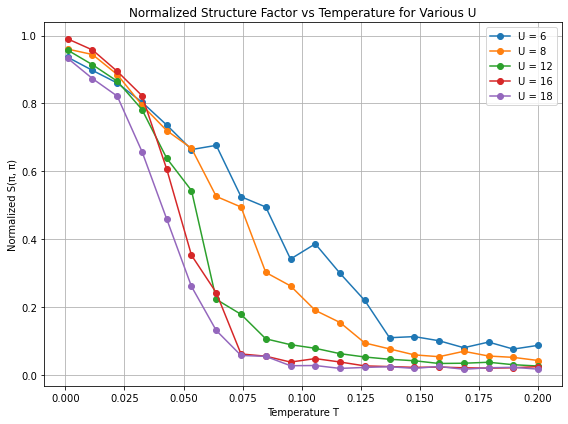

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Base directory where your CSVs are stored (adjust if needed)
base_path_18 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_18"
base_path_16 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_16"
base_path_12 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_12"
base_path_8 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_8"
base_path_6 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_6"

# Dictionary of U values and their corresponding files
csv_files = {
    6: base_path_6 / "normalized_structure_factor_vs_T_6.csv",
    8: base_path_8 / "normalized_structure_factor_vs_T_8.csv",
    12: base_path_12 / "normalized_structure_factor_vs_T_12.csv",
    16: base_path_16 / "normalized_structure_factor_vs_T_16.csv",
    18: base_path_18 / "normalized_structure_factor_vs_T_18.csv"
}

# Plot
plt.figure(figsize=(8, 6))
for U_val, file_path in csv_files.items():
    try:
        df = pd.read_csv(file_path)
        plt.plot(df['T'], df['Normalized_S_pi_pi'], marker='o', label=f'U = {U_val}')
    except FileNotFoundError:
        print(f"⚠️ File not found for U = {U_val}: {file_path}")

plt.xlabel('Temperature T')
plt.ylabel('Normalized S(π, π)')
plt.title('Normalized Structure Factor vs Temperature for Various U')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Histograms plot for comparison

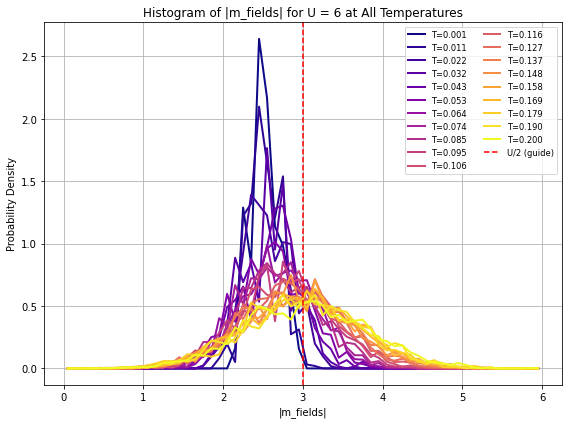

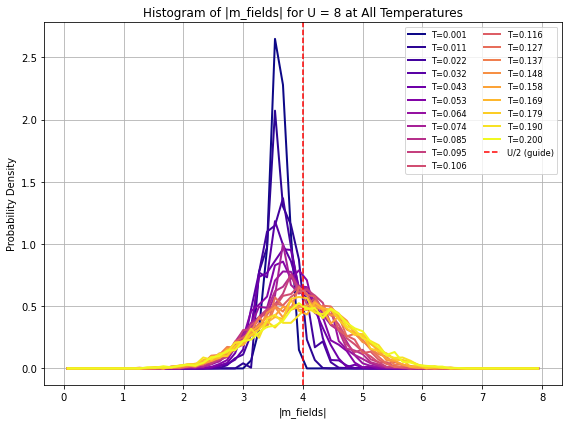

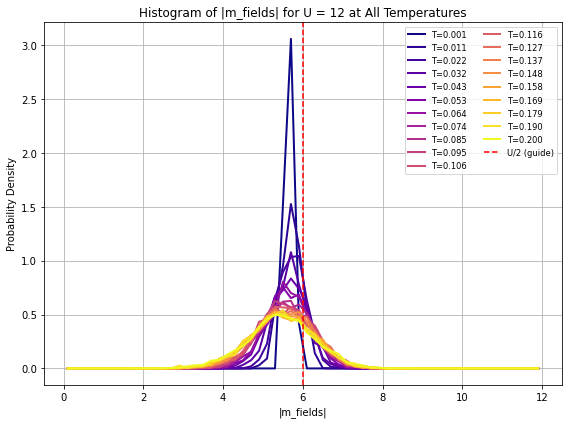

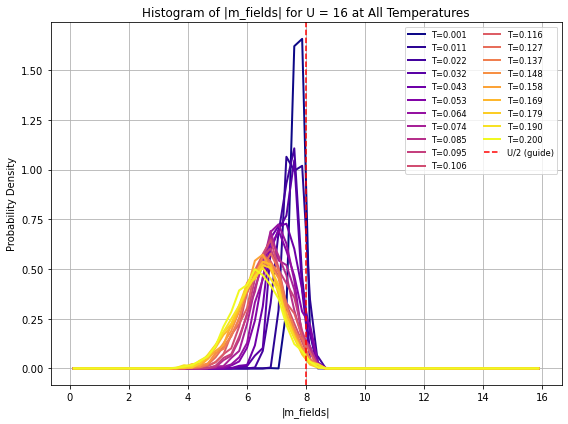

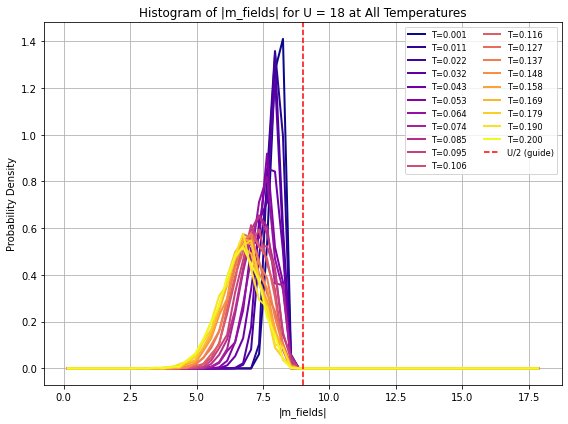

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set base path to Desktop histogram folder
base_path_18 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_18"
base_path_16 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_16"
base_path_12 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_12"
base_path_8 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_8"
base_path_6 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_6"

# Define histogram files per U value
histogram_files = {
    6: base_path_6 / "m_histogram_data_6.csv",
    8: base_path_8 / "m_histogram_data_8.csv",
    12: base_path_12 / "m_histogram_data_12.csv",
    16: base_path_16 / "m_histogram_data_16.csv",
    18: base_path_18 / "m_histogram_data_18.csv"
}

# Load and concatenate all histograms
hist_df_all = pd.concat([
    pd.read_csv(path).assign(U=U_val)
    for U_val, path in histogram_files.items()
    if path.exists()
], ignore_index=True)

# Get unique U values
unique_Us = sorted(hist_df_all["U"].unique())

# Plot histograms grouped by U
for U in unique_Us:
    subset_U = hist_df_all[hist_df_all["U"] == U]
    T_vals = sorted(subset_U["T"].unique())
    colors = plt.cm.plasma(np.linspace(0, 1, len(T_vals)))

    plt.figure(figsize=(8, 6))
    for i, T in enumerate(T_vals):
        subset = subset_U[np.isclose(subset_U["T"], T)]
        m_vals = subset["m_magnitude"].values

        hist, bins = np.histogram(m_vals, bins=60, range=[0, U], density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bin_centers, hist, lw=2, color=colors[i], label=f"T={T:.3f}")

    plt.xlabel("|m_fields|")
    plt.ylabel("Probability Density")
    plt.title(f"Histogram of |m_fields| for U = {U} at All Temperatures")
    plt.axvline(x=U / 2, color='red', linestyle='--', label='U/2 (guide)')
    plt.legend(fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Plotting Density of States (DOS)

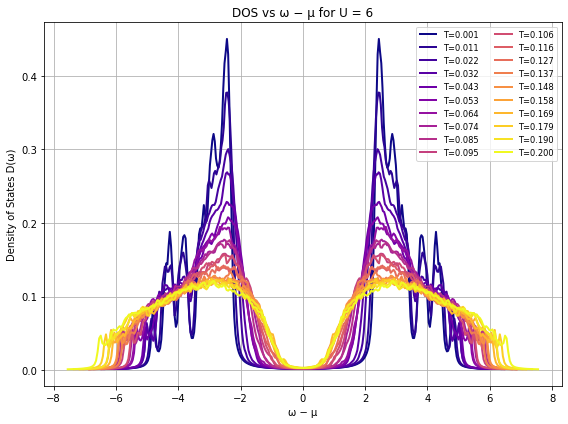

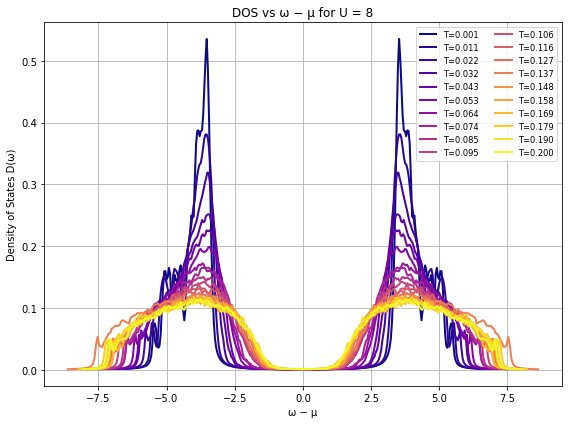

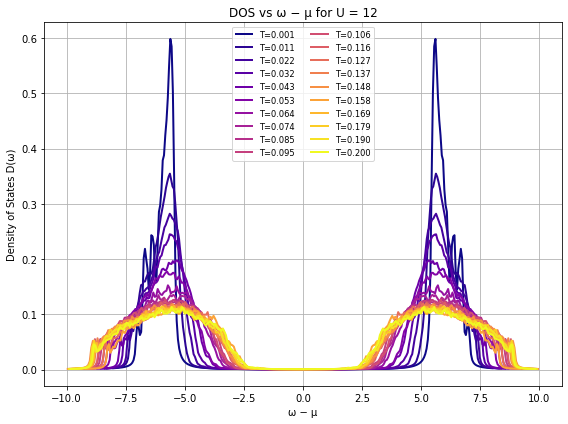

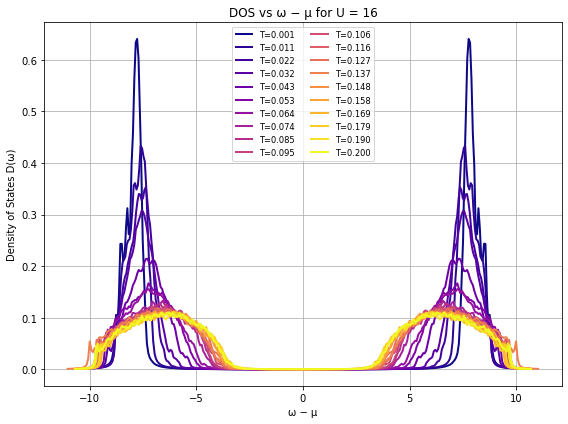

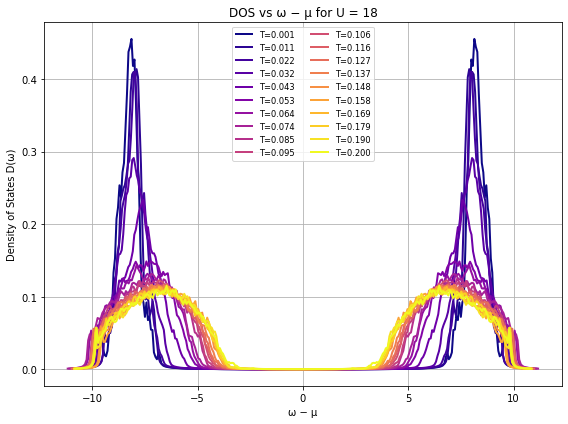

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 📁 Define base directory where your CSVs are stored
base_path_18 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_18"
base_path_16 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_16"
base_path_12 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_12"
base_path_8 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_8"
base_path_6 = Path.home() / "Desktop" / "Aux_Field_Output" / "U_6"

# 🔗 Map U values to their corresponding DOS CSV files
dos_files = {
    6: base_path_6 / "dos_data_6.csv",
    8: base_path_8 / "dos_data_8.csv",
    12: base_path_12 / "dos_data_12.csv",
    16: base_path_16 / "dos_data_16.csv",
    18: base_path_18 / "dos_data_18.csv",
}

# 🔁 Loop through each U and plot DOS
for U_val, file_path in dos_files.items():
    if not file_path.exists():
        print(f"⚠️ File not found for U = {U_val}: {file_path}")
        continue

    # Load the CSV
    dos_df = pd.read_csv(file_path)

    # Unique temperatures
    T_vals = sorted(dos_df["T"].unique())
    colors = plt.cm.plasma(np.linspace(0, 1, len(T_vals)))

    # Plot for each temperature
    plt.figure(figsize=(8, 6))
    for i, T in enumerate(T_vals):
        df_T = dos_df[np.isclose(dos_df["T"], T)]
        plt.plot(df_T["omega_minus_mu"], df_T["dos"], label=f"T={T:.3f}", color=colors[i], lw=2)

    plt.xlabel("ω − μ")
    plt.ylabel("Density of States D(ω)")
    plt.title(f"DOS vs ω − μ for U = {U_val}")
    plt.grid(True)
    plt.legend(fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()


# Local density

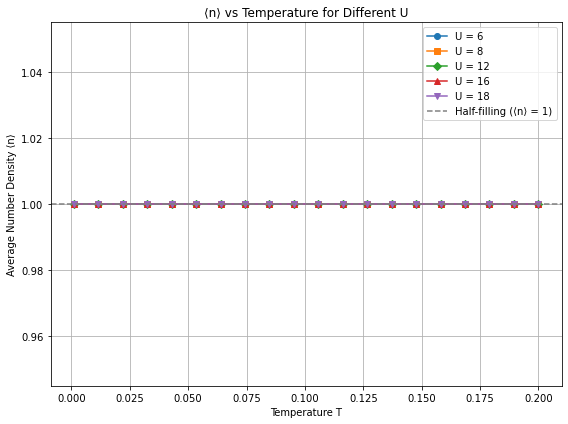

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 📁 Define base directories for each U
base_dirs = {
    6: Path.home() / "Desktop" / "Aux_Field_Output" / "U_6",
    8: Path.home() / "Desktop" / "Aux_Field_Output" / "U_8",
    12: Path.home() / "Desktop" / "Aux_Field_Output" / "U_12",
    16: Path.home() / "Desktop" / "Aux_Field_Output" / "U_16",
    18: Path.home() / "Desktop" / "Aux_Field_Output" / "U_18"
}

# 🔗 Map U values to number density CSVs
n_density_files = {
    U: base / f"n_density_vs_T_{U}.csv"
    for U, base in base_dirs.items()
}

# 🎨 Marker styles to cycle through
markers = ['o', 's', 'D', '^', 'v', '*', 'X', 'P', 'h', '+']
marker_map = {U: markers[i % len(markers)] for i, U in enumerate(n_density_files)}

# 📊 Plot setup
plt.figure(figsize=(8, 6))

# 🔁 Loop through each U's file and plot
for U_val, file_path in n_density_files.items():
    if not file_path.exists():
        print(f"⚠️ File not found for U = {U_val}: {file_path}")
        continue

    df = pd.read_csv(file_path)
    df = df.sort_values(by="T")
    marker = marker_map[U_val]
    plt.plot(df['T'], df['avg_n'], marker=marker, label=f'U = {U_val}', linestyle='-')

# 🧾 Final formatting
plt.xlabel('Temperature T')
plt.ylabel('Average Number Density ⟨n⟩')
plt.title('⟨n⟩ vs Temperature for Different U')
plt.axhline(1.0, color='gray', linestyle='--', label='Half-filling (⟨n⟩ = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Ground State Energy Gap Checking

In [1]:
import numpy as np
from scipy.linalg import eigh

# --- Parameters ---
L = 8
N = L * L
t = 1.0 # should not this be zero in the ground state?
U = 16
T = 0.0001
beta = 1.0 / T
mu = (U / 2)

'''# --- Initialize random magnetic fields ---
def initialize_fields(L):
    m1_fields = np.zeros((L, L, 3))
    #print('1',m1_fields)
    #m1_fields[:, :, 0] = np.random.uniform(-5, 5, size=(L, L))  # m_x
    #print('2',m1_fields[:, :, 0])
    #m1_fields[:, :, 1] = np.random.uniform(-5, 5, size=(L, L))  # m_y
    #print('3',m1_fields[:, :, 1])
    m1_fields[:, :, 2] = np.random.uniform(-5, 5, size=(L, L))  # m_z
    #print('4',m1_fields[:, :, 2])
    #print('5',m1_fields)
    return m1_fields'''

def generate_checkerboard_mz(L, U):
    m_fields = np.zeros((L, L, 3))
    for x in range(L):
        for y in range(L):
            i = x * L + y
            mz = (U / 2) * ((-1) ** i)
            m_fields[x, y, 2] = mz  # only mz is non-zero
    return m_fields

# Replace initialization with:
m_fields = generate_checkerboard_mz(L, U)
print('m_fields', m_fields)


# --- Build Effective Hamiltonian ---
def build_effective_hamiltonian(m_fields, t, mu, U):
    H_upup = np.zeros((N, N), dtype=np.complex128)
    H_downdown = np.zeros((N, N), dtype=np.complex128)
    H_updown = np.zeros((N, N), dtype=np.complex128)
    H_downup = np.zeros((N, N), dtype=np.complex128)

    for x in range(L):
        for y in range(L):
            i = x * L + y
            mx, my, mz = m_fields[x, y]
            H_upup[i, i] = -1 * mz - (mu - U / 2)
            H_downdown[i, i] = +1 * mz - (mu - U / 2)
            B = -1 * (mx - 1j * my)
            H_updown[i, i] = B
            H_downup[i, i] = np.conj(B)

            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                x_nn = (x + dx) % L
                y_nn = (y + dy) % L
                j = x_nn * L + y_nn
                H_upup[i, j] = H_upup[j, i] = -t
                H_downdown[i, j] = H_downdown[j, i] = -t

    top = np.hstack((H_upup, H_updown))
    bottom = np.hstack((H_downup, H_downdown))
    return np.vstack((top, bottom))

H = build_effective_hamiltonian(m_fields, t, mu, U)
eigvals, eigvecs = eigh(H)

print('eigvals\n', eigvals)

eigvals_sorted = np.sort(eigvals)
mid = len(eigvals_sorted) // 2
print("Occupied max:", eigvals_sorted[mid - 1])
print("Unoccupied min:", eigvals_sorted[mid])
print("Gap =", eigvals_sorted[mid] - eigvals_sorted[mid - 1])

'''# --- Fermi & Energy ---
def fermi_dirac(E, mu, beta):
    return 1.0 / (np.exp(beta * E) + 1.0)'''

def fermi_dirac(E, mu, beta):
    x = beta * (E)
    result = np.empty_like(x)

    # Case 1: x > 700 — use safe approximation
    mask_large = x > 700
    result[mask_large] = np.exp(-x[mask_large])  # this is numerically safe

    # Case 2: x ≤ 700 — compute directly
    mask_small = ~mask_large
    result[mask_small] = 1.0 / (np.exp(x[mask_small]) + 1.0)

    return result


def compute_local_densities(eigvals, eigvecs, mu, beta):
    N2 = eigvecs.shape[0]
    N = N2 // 2
    local_up = np.zeros(N)
    local_down = np.zeros(N)
    for i in range(N):
        for alpha in range(N2):
            f_occ = fermi_dirac(eigvals[alpha], mu, beta)
            local_up[i] += f_occ * (abs(eigvecs[i, alpha]))**2
            local_down[i] += f_occ * (abs(eigvecs[i + N, alpha]))**2
    return local_up, local_down

local_up, local_down = compute_local_densities(eigvals, eigvecs, mu, beta)
n_total = np.mean(local_up + local_down)

print(f"⟨n⟩ = {n_total:.6f}")



m_fields [[[ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]]

 [[ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]]

 [[ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]]

 [[ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]]

 [[ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]]

 [[ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]]

 [[ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]]

 [[ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
  [ 0.  0. -8.]
  [ 0.  0.  8.]
 

L = 8, Gap = 15.600000
L = 10, Gap = 15.600477
L = 12, Gap = 15.600000
L = 14, Gap = 15.600248
L = 16, Gap = 15.600000
L = 18, Gap = 15.600151
L = 20, Gap = 15.600000
L = 22, Gap = 15.600101
L = 24, Gap = 15.600000
L = 26, Gap = 15.600073


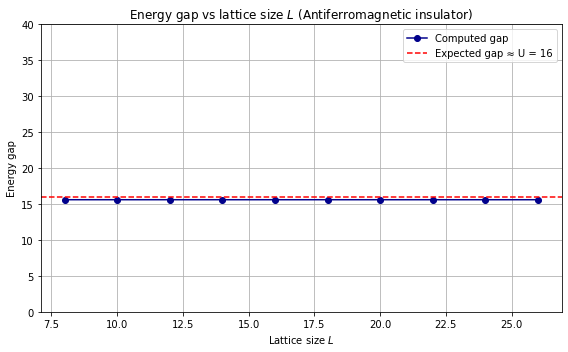

In [6]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

# --- Parameters ---
t = 0.1
U = 16
T = 0.0001
beta = 1.0 / T
mu = U / 2

def generate_checkerboard_mz(L, U):
    m_fields = np.zeros((L, L, 3))
    for x in range(L):
        for y in range(L):
            i = x * L + y
            mz = (U / 2) * ((-1) ** i)
            m_fields[x, y, 2] = mz
    return m_fields

def build_effective_hamiltonian(m_fields, t, mu, U):
    L = m_fields.shape[0]
    N = L * L
    H_upup = np.zeros((N, N), dtype=np.complex128)
    H_downdown = np.zeros((N, N), dtype=np.complex128)
    H_updown = np.zeros((N, N), dtype=np.complex128)
    H_downup = np.zeros((N, N), dtype=np.complex128)

    for x in range(L):
        for y in range(L):
            i = x * L + y
            mx, my, mz = m_fields[x, y]
            H_upup[i, i] = -1 * mz - (mu - U / 2)
            H_downdown[i, i] = +1 * mz - (mu - U / 2)
            B = -1 * (mx - 1j * my)
            H_updown[i, i] = B
            H_downup[i, i] = np.conj(B)

            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                x_nn = (x + dx) % L
                y_nn = (y + dy) % L
                j = x_nn * L + y_nn
                H_upup[i, j] = H_upup[j, i] = -t
                H_downdown[i, j] = H_downdown[j, i] = -t

    top = np.hstack((H_upup, H_updown))
    bottom = np.hstack((H_downup, H_downdown))
    return np.vstack((top, bottom))

# --- Main Loop over L ---
L_values = list(range(8, 28, 2))  # L = 8, 10, ..., 26
gaps = []

for L in L_values:
    N = L * L
    m_fields = generate_checkerboard_mz(L, U)
    H = build_effective_hamiltonian(m_fields, t, mu, U)
    eigvals, _ = eigh(H)
    eigvals_sorted = np.sort(eigvals)
    mid = len(eigvals_sorted) // 2
    gap = eigvals_sorted[mid] - eigvals_sorted[mid - 1]
    gaps.append(gap)
    print(f"L = {L}, Gap = {gap:.6f}")

# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(L_values, gaps, marker='o', linestyle='-', color='darkblue', label='Computed gap')
plt.ylim(0,40)
plt.axhline(y=U, color='red', linestyle='--', label=f'Expected gap ≈ U = {U}')
plt.xlabel('Lattice size $L$')
plt.ylabel('Energy gap')
plt.title('Energy gap vs lattice size $L$ (Antiferromagnetic insulator)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gap_vs_L.png", dpi=300)
plt.show()
